In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

% matplotlib inline

In [2]:
# Define the free energies

L_Ni = 2310*8.42    # J/mol
L_Cu = 1728*6.42    # J/mol
R    = 8.314        # J/mol

V_Ni = 8.42         # cm^3
V_Cu = 6.42         # cm^3
V_L  = 7.42         # cm^3

T_Ni = 1453+273     # K
T_Cu = 1085+273     # K


# Definitions (Free energies)

def G_s(X,T):
    
    return (1-X)*L_Ni*(T-T_Ni)/T_Ni + X*L_Cu*(T-T_Cu)/T_Cu + R*T*((1-X)*np.log(1-X) + X*np.log(X))

def G_l(X,T):
    
    return R*T*((1-X)*np.log(1-X) + X*np.log(X))

G_s = np.vectorize(G_s)
G_l = np.vectorize(G_l)


# Molar free energies for pure components

def G_Ni_s(T):
    
    return L_Ni*(T-T_Ni)/T_Ni

def G_Cu_s(T):
    
    return L_Cu*(T-T_Cu)/T_Cu

# diffs

def Gp_s(X,T):
    
    return -G_Ni_s(T) + G_Cu_s(T) + R*T*(np.log(X)-np.log(1-X))

def Gp_l(X,T):
    
    return R*T*(np.log(X)-np.log(1-X))

# Chemical potentials:

def mu_Cu_s(X_Cu_s,T):
    
    return G_s(X_Cu_s,T) + (1-X_Cu_s)*Gp_s(X_Cu_s,T)
    
def mu_Ni_s(X_Cu_s,T):
    
    return G_s(X_Cu_s,T) - X_Cu_s*Gp_s(X_Cu_s,T)

def mu_Cu_l(X_Cu_l,T):
    
    return G_l(X_Cu_l,T) + (1-X_Cu_l)*Gp_l(X_Cu_l,T)

def mu_Ni_l(X_Cu_l,T):
    
    return G_l(X_Cu_l,T) - X_Cu_l*Gp_l(X_Cu_l,T)



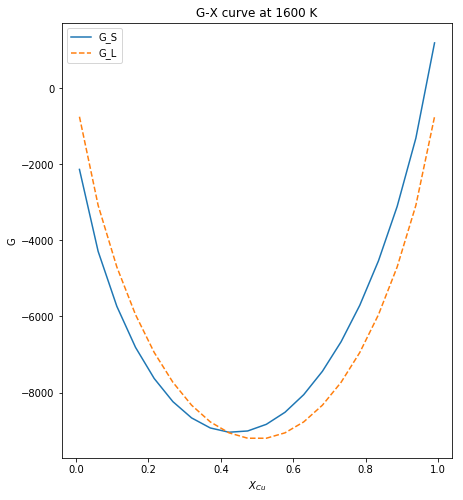

In [3]:
sample = np.linspace(0.01,0.99,20)

T=1600

fig,ax = plt.subplots(figsize=(7,8))
ax.set_title('G-X curve at ' + str(T) + ' K')
ax.plot(sample, G_s(sample,T),label='G_S')
ax.plot(sample, G_l(sample,T),linestyle='dashed',label='G_L')
ax.set_xlabel('$X_{Cu}$')
ax.set_ylabel('G')
ax.legend()

plt.show()



fig.savefig('G-X_1600K')

In [4]:
# Solving for equilibrium conditions

number = 371
temp_range = np.linspace(1360,1730,number)

solutions = np.zeros([number,3])


def equations(X_Cu,T):
    
    X_s, X_l = X_Cu
    
    fun1 = G_Ni_s(T) + R*T*np.log(1-X_s) - R*T*np.log(1-X_l)
    fun2 = G_Cu_s(T) + R*T*np.log(X_s) - R*T*np.log(X_l)
    
    return fun1,fun2


for i in range(number):
    
    x_s,x_l = opt.fsolve(equations, [0.4,0.6], temp_range[i])
    solutions[i] = [temp_range[i],x_s,x_l]
    
solved = solutions[solutions[:,1] != 0.4]

/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/home/rohith/installations/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/rohith/installations/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [5]:
solved.shape

(371, 3)

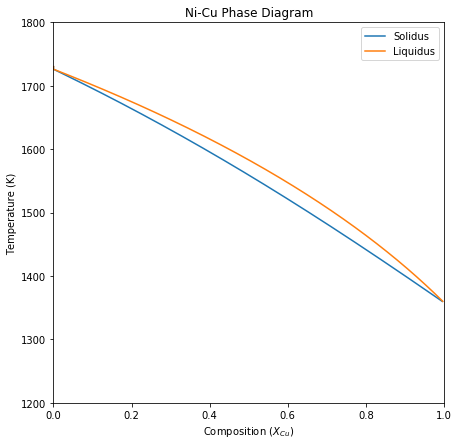

In [6]:
fig, ax = plt.subplots(figsize = (7,7))

ax.set_ylabel('Temperature (K)')
ax.set_xlabel('Composition ($X_{Cu}$)')
ax.set_xlim(0,1)
ax.set_ylim(1200,1800)
ax.set_title('Ni-Cu Phase Diagram')

ax.plot(solved[:,1],solved[:,0], label='Solidus')
ax.plot(solved[:,2],solved[:,0], label='Liquidus')

ax.legend()

fig.savefig('Phase_diagram')

# Let's save the phase diagram as a csv file

np.savetxt("Ni-Cu-PhaseDiagram.csv",solved,delimiter=',')

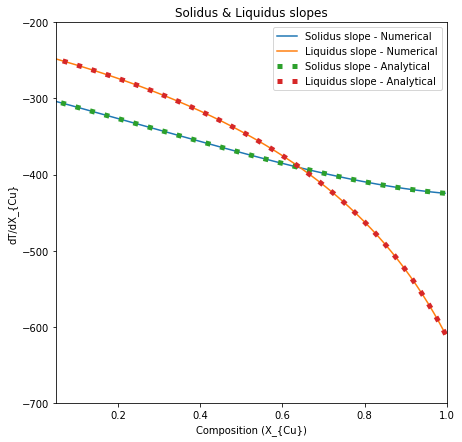

In [8]:
# computing slopes of liquidus and solidus
# And also comparing with analytical solution:

solidus_diff = np.gradient(solved[:,0],solved[:,1])  # numerical solution
liquidus_diff = np.gradient(solved[:,0],solved[:,2]) # numerical solution

# Analytical solutions

def solidus_slope(T,X_s,X_l):
    
    return R*T*T*((X_s - X_l)/(X_s*(1-X_s)*((1-X_l)*L_Ni + X_l*L_Cu)))

def liquidus_slope(T,X_s,X_l):
    
    return R*T*T*((X_s - X_l)/(X_l*(1-X_l)*((1-X_s)*L_Ni + X_s*L_Cu)))

solid_slopes = [solidus_slope(solved[i,0],solved[i,1],solved[i,2]) for i in range(solved.shape[0])]

liquid_slopes = [liquidus_slope(solved[i,0],solved[i,1],solved[i,2]) for i in range(solved.shape[0])]


# Plotting

fig, ax = plt.subplots(figsize = (7,7))

ax.set_ylabel('dT/dX_{Cu}')
ax.set_xlabel('Composition (X_{Cu})')
ax.set_xlim(0.05,1)
ax.set_ylim(-700,-200)
ax.set_title('Solidus & Liquidus slopes')

ax.plot(solved[:,1],solidus_diff, label='Solidus slope - Numerical')
ax.plot(solved[:,2],liquidus_diff, label='Liquidus slope - Numerical')

ax.plot(solved[:,1],solid_slopes, label='Solidus slope - Analytical', linestyle=(0,(1,2)), linewidth=5)
ax.plot(solved[:,2],liquid_slopes, label='Liquidus slope - Analytical', linestyle=(0,(1,2)), linewidth=5)



ax.legend()

fig.savefig('Soliquidus_slope')

In [9]:
# Finding Driving force values (for given undercooling dT)

def driv_equation(X_Cu_s, X_Cu_l, T, dT):
    
    return mu_Ni_l(X_Cu_l, T-dT) - mu_Ni_s(X_Cu_s, T-dT) - (mu_Cu_l(X_Cu_l,T-dT) - mu_Cu_s(X_Cu_s,T-dT))*V_Ni/V_Cu

# Solving for X_Cu_s (At specific undercooling)
# Solns are in the form [X_Cu_s,X_Cu_l,T]. X_Cu_s is equilibrium composition at given undercooling

solns_1K = np.array([np.array([opt.fsolve(driv_equation, 0.2, (solved[i,2], solved[i,0], 1))[0],solved[i,2],solved[i,0]]) for i in range(solved.shape[0])])
solns_1K = solns_1K[solns_1K[:,0] !=0.2]

solns_10K = np.array([np.array([opt.fsolve(driv_equation, 0.2, (solved[i,2], solved[i,0], 10))[0],solved[i,2],solved[i,0]]) for i in range(solved.shape[0])])
solns_10K = solns_10K[solns_10K[:,0] !=0.2]

solns_01K = np.array([np.array([opt.fsolve(driv_equation, 0.2, (solved[i,2], solved[i,0], 0.1))[0],solved[i,2],solved[i,0]]) for i in range(solved.shape[0])])
solns_01K = solns_01K[solns_01K[:,0]!=0.2]

/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log
/home/rohith/installations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log
/home/rohith/installations/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [10]:
# Compute driving forces. Values are in J/cm^3

def calc_deltaP(X_Cu_s,X_Cu_l,T):
    
    delta_P = (mu_Cu_l(X_Cu_l,T) - mu_Cu_s(X_Cu_s,T))/V_Cu
    
    return delta_P

delta_P_1K = np.array([calc_deltaP(solns_1K[i,0],solns_1K[i,1],solns_1K[i,2]-1) for i in range(solns_1K.shape[0])])
delta_P_10K = np.array([calc_deltaP(solns_10K[i,0],solns_10K[i,1],solns_10K[i,2]-100) for i in range(solns_10K.shape[0])])
delta_P_01K = np.array([calc_deltaP(solns_01K[i,0],solns_01K[i,1],solns_01K[i,2]-0.001) for i in range(solns_01K.shape[0])])

In [11]:
# Compute appx. driving force


def calc_deltaP_appx(X_Cu_s,X_Cu_l,T,dT):
    
    mu_eq = mu_Ni_s(1-X_Cu_s,T) - mu_Cu_s(X_Cu_s,T)
    mu_dT = mu_Ni_s(1-X_Cu_s,T-dT) - mu_Cu_s(X_Cu_s,T-dT)
    
    S_s = L_Ni*(1-X_Cu_s)/T_Ni + L_Cu*X_Cu_s/T_Cu + R*(X_Cu_s*np.log(X_Cu_s)+(1-X_Cu_s)*np.log(1-X_Cu_s))
    S_l = R*(X_Cu_l*np.log(X_Cu_l)+(1-X_Cu_l)*np.log(1-X_Cu_l))
    
    appx_delta_P = ((X_Cu_s - X_Cu_l)*(mu_dT - mu_eq) + (S_s - S_l)*dT)/V_L
    
    return appx_delta_P

appx_delta_P_1K = np.array([calc_deltaP_appx(solved[i,1],solved[i,2],solved[i,0],1) for i in range(solved.shape[0])])
appx_delta_P_01K = np.array([calc_deltaP_appx(solved[i,1],solved[i,2],solved[i,0],0.1) for i in range(solved.shape[0])])
appx_delta_P_10K = np.array([calc_deltaP_appx(solved[i,1],solved[i,2],solved[i,0],10) for i in range(solved.shape[0])])



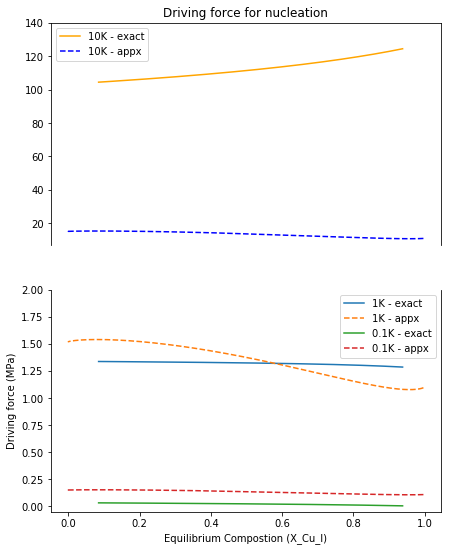

In [12]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (7,9))

ax2.set_ylabel('Driving force (MPa)')
ax2.set_xlabel('Equilibrium Compostion (X_Cu_l)')

ax1.set_title('Driving force for nucleation')

ax2.plot(solns_1K[30:,1],delta_P_1K[30:], label='1K - exact')
ax2.plot(solved[:,2],appx_delta_P_1K, label='1K - appx',linestyle='--')

ax2.plot(solns_01K[30:,1],delta_P_01K[30:], label='0.1K - exact')
ax2.plot(solved[:,2],appx_delta_P_01K, label='0.1K - appx',linestyle='--')

ax2.set_ylim(-0.05,2)

ax1.plot(solns_1K[30:,1],delta_P_10K[30:], label='10K - exact', c='orange')
ax1.plot(solved[:,2],appx_delta_P_10K, label='10K - appx', c='blue',linestyle='--')

ax1.set_ylim(7,140)

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) #

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.legend()
ax2.legend()

fig.savefig('Driving_force')


In [13]:
# Critical curvature for equilibrium liquid at 1500K, undercooling of 1K

print(solns_1K[136,2],delta_P_1K[136])

crit_curv = delta_P_1K[136]*1000000/0.1*2
print(crit_curv)

radius = 1/crit_curv
print(radius)

1500.0 1.310716613410211
26214332.268204223
3.8147071219239705e-08


In [ ]:
# some calculations for future reference